In [ ]:
# install packages
import sys
!{sys.executable} -m pip install networkx
!{sys.executable} -m pip install matplotlib
!{sys.executable} -m pip install numpy

In [2]:
from collections import defaultdict
import matplotlib
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

from graph_utils import *

plt.rcParams.update({'font.size': 16})

In [3]:
# figure parameters
fig_size = 6


small_size = 25
large_size = 100

In [4]:
def BFS(adjacency_dict, target,start=1):
    """Perform breadth first search for 'true' targets given adjacency dictionary"""
    
    # keep track of vertices that have been visited
    visited_bfs = [start]
    
    # keep track of the "next layer" of vertices
    next_layer = [start]
    num_steps = 0
    
    # stop when there are no more "layers" of vertices to visit
    while (len(next_layer) > 0):
        
        current_layer = next_layer
        next_layer = []
        
        # visit each vertex in the current layer
        for vertex in current_layer:
            
            # add the neighbors of each vertex in the current layer to the next layer
            for neighbor in [x for x in adjacency_dict[vertex] if x not in visited_bfs]:
                num_steps += 1
                
                # check whether each neighbor is 'true'; if so, stop the search
                if target[neighbor]:
                    return neighbor, num_steps, visited_bfs
                else:
                    visited_bfs.append(neighbor)
                next_layer.append(neighbor)
    return None, num_steps, visited_bfs

In [5]:
def DFS(adjacency_dict, target, start = 1):
    return call_DFS(adjacency_dict, target,start=start, current = start, visited_dfs = [start])

def call_DFS(adjacency_dict, target, start=1, current = 1, visited_dfs = [1], backtrack = {}):
    """Perform depth first search for 'true' targets given adjacency dictionary"""
    
    # Find all unvisited neighbors of current vertex
    unvisited_neighbors = [x for x in adjacency_dict[current] if x not in visited_dfs]
    
    # if there are no unvisited neighbors, every vertex "further down" in the tree has been searched
    # Backtrack to the previous vertex and perform DFS from there
    if len(unvisited_neighbors) == 0:
        if current == start:
            return None, len(visited_dfs), visited_dfs
        return call_DFS(adjacency_dict, target, start = start,current = backtrack[current],visited_dfs = visited_dfs,backtrack = backtrack)

    # choose an unvisited vertex, neighbor of the current vertex, to visit next
    next_vertex = min(unvisited_neighbors)

    # keep track of the edge between the current vertex and the next vertex so 
    # we can backtrack in the future if necessary
    backtrack[next_vertex] = current
    
    # if the next vertex is 'true', return it
    if target[next_vertex]:
        return next_vertex, len(visited_dfs), visited_dfs
    
    # if not, mark that the next vertex has been visited, and continue the algorithm from there
    visited_dfs.append(next_vertex)
    return call_DFS(adjacency_dict, target, start=start,current = next_vertex,visited_dfs = visited_dfs,backtrack = backtrack)

# Search Algorithms

In [6]:
# CHANGE HERE

seed = 123              #random seed; change to allow for a different graph with the same parameters
vertex_limit = 35       # at least this number of vertices will be included in the graph
poisson_param = 3       # Determines the expected number of neighbors of each vertex has (larger means more neighbors)

# p = 0.6                 # Determines how frequent solutions will be in the graph
# close_solutions = False # Determines whether the solutions sill be located closer or farther from the start

p = 0.4
close_solutions = True

In [7]:
adjacency_dict, target, colors, sizes, g, my_pos = create_search_tree(vertex_limit, poisson_param, p, seed, close_solutions)

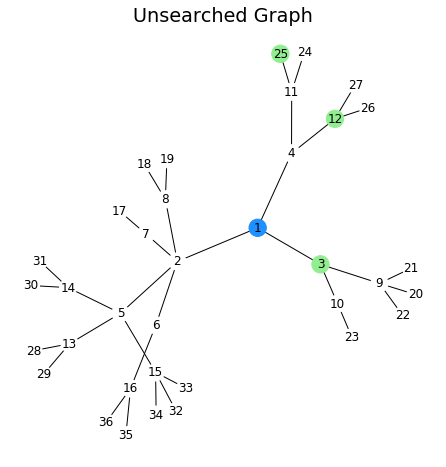

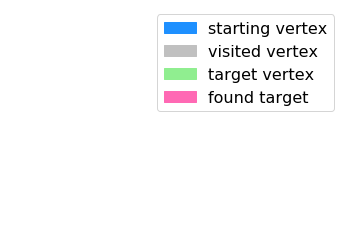

In [8]:

plt.figure(figsize=(fig_size,fig_size)) 
# ,node_size=sizes
nx.draw(g, pos=my_pos, node_color = colors,with_labels=True)
plt.title("Unsearched Graph")
plt.show()
plot_search_palette()

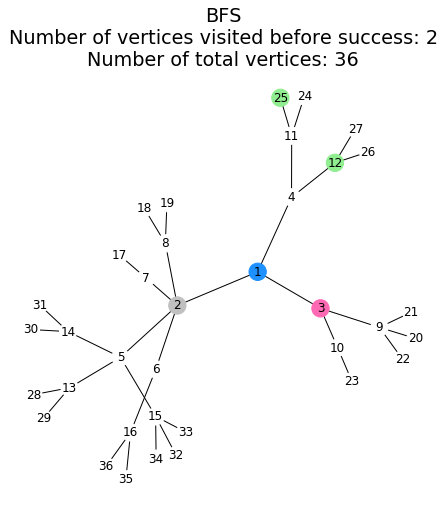

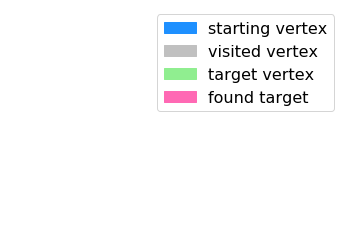

In [9]:
np.random.seed(123)
plt.figure(figsize=(fig_size,fig_size)) 

found_vertex, num_steps, visited = BFS(adjacency_dict, target)

BFS_colors = colors.copy()
BFS_sizes = sizes.copy()
for v in visited:
    if v != 1:
        BFS_colors[v-1] = "silver"
        BFS_sizes[v - 1] = large_size
if found_vertex is not None:
    BFS_colors[found_vertex-1] = "hotpink"
    #node_size = BFS_sizes,
nx.draw(g, pos=my_pos, node_color = BFS_colors, with_labels=True)
plt.title("BFS\nNumber of vertices visited before success: {}\nNumber of total vertices: {}".format(num_steps,max(adjacency_dict)))
plt.show()
plot_search_palette()

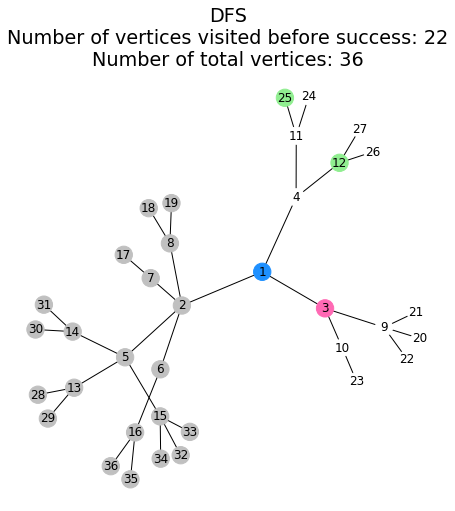

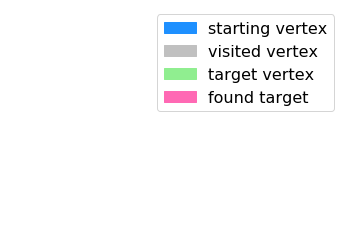

In [10]:
np.random.seed(123)
plt.figure(figsize=(fig_size,fig_size)) 


fv, ns, vd  = DFS(adjacency_dict, target, start = 1)
DFS_colors = colors.copy()
DFS_sizes = sizes.copy()
for v in vd:
    if v != 1:
        DFS_colors[v-1] = "silver"
        DFS_sizes[v - 1] = large_size
if fv is not None:
    DFS_colors[fv-1] = "hotpink"
# node_size = DFS_sizes,
nx.draw(g, pos=my_pos, node_color = DFS_colors, with_labels=True)
plt.title("DFS\nNumber of vertices visited before success: {}\nNumber of total vertices: {}".format(ns,max(adjacency_dict)))

plt.show()
plot_search_palette()

# Minimum spanning tree

In [11]:
def kruskal(adjacency_dict, weights):
    """Perform Kruskal's algorithm for finding a minimum weight spanning tree"""
    
    # sort edges in increasing order by weight
    sorted_edges = sorted(weights, key=weights.get)

    # keep track of the weight of the tree
    weight = 0

    # initialize empty graph to build the tree
    min_tree = {k : [] for k in adjacency_dict.keys()}

    # if the graph is not connected, it is impossible to build a tree
    if not is_connected(adjacency_dict):
        return None
    
    # keep track of the current edge under consideration
    edge_index = 0
    
    # Continue until the tree we're building is connected
    while (not is_connected(min_tree)):
        
        # try adding the next edge to the graph
        edge = sorted_edges[edge_index]
        min_tree[edge[0]].append(edge[1])
        min_tree[edge[1]].append(edge[0])

        # if adding this edge causes the tree to have a cycle, delete it
        if contains_cycle(min_tree):
            min_tree[edge[0]] = min_tree[edge[0]][:-1]
            min_tree[edge[1]] = min_tree[edge[1]][:-1]
        
        else:
            weight += weights[(edge[0],edge[1])]
        edge_index += 1
    return min_tree,weight

In [12]:
def is_connected(adjacency_dict):
    """Given an adjacency dictionary determine whether the graph is connected"""

    # Run DFS from a vertex
    _, _, visited = DFS(adjacency_dict, defaultdict(lambda : False), list(adjacency_dict.keys())[0])

    # If DFS visits every vertex, the graph is connected; otherwise it's not
    if len(visited) < len(adjacency_dict):
        return False
    return True

In [13]:
def contains_cycle(adjacency_dict):
    """Check whether a graph contains a cycle given an adjacency dictionary"""

    # keep track of all unvisited vertices
    unvisited = list(adjacency_dict.keys())

    # continue until all vertices have been visited
    while(len(unvisited) > 0):

        # Run DFS from an unvisited vertex and find all vertices reachable from that vertex (a component)
        _, _, visited = DFS(adjacency_dict, defaultdict(lambda : False), unvisited[0])

        # count the number of degrees in the component
        component_degrees = 0
        for k, v in adjacency_dict.items():
            if k in visited:
                component_degrees += len([i for i in v if i in visited])

        # number of degrees = 2 * number of edges
        component_edges = component_degrees/2

        # If a connected component on n vertices has n - 1 edges, it's a tree; otherwise, it has a cycle
        if component_edges > len(visited) - 1:
            return True
        unvisited = [i for i in unvisited if i not in visited]
    return False

In [22]:
# CHANGE HERE

seed = 123        # random seed (change to allow a different random graph with the same parameters)
min_edges = 7    # minimum number of edges in the graph

# num_vertices = 5 # number of vertices in the graph
num_vertices = 15 # number of vertices in the graph


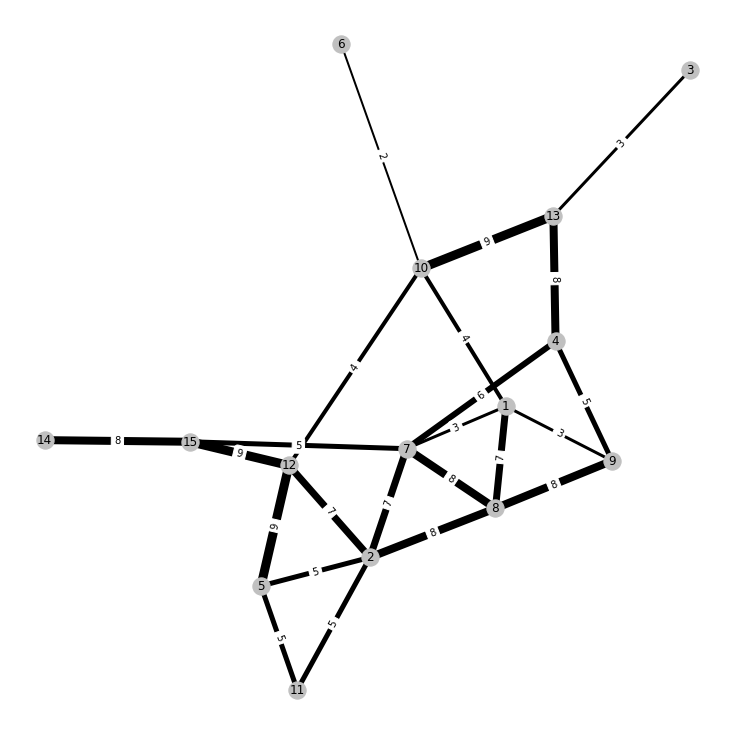

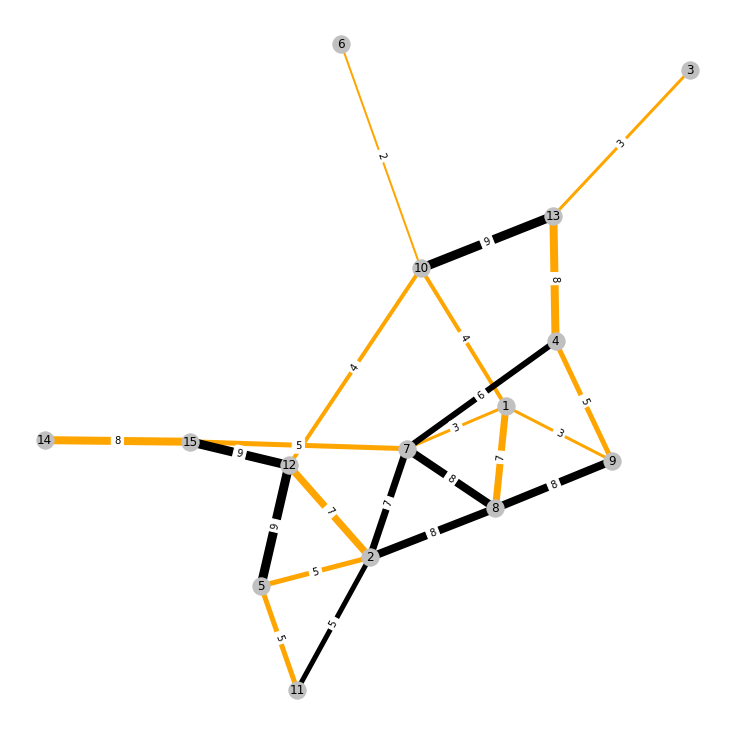

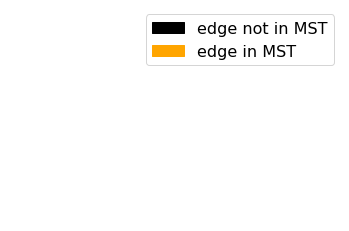

In [23]:

np.random.seed(seed)
adj,weights = create_graph(num_vertices,min_edges,True)
draw_adj(adj,weights,True)

tree, weight = kruskal(adj, weights)
draw_adj(adj,weights,True, tree)

plot_kruskal_palette()